In [4]:
import pyxdameraulevenshtein

In [5]:
import sys
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.tsa.stattools as stats
import statsmodels.tsa.statespace.tools as statstools
from statsmodels.tsa.api import VAR, DynamicVAR
from matplotlib import pyplot as plt
import itertools

sys.path.append("..") # Adds higher directory to python modules path for importing from src dir
from src.datasets import NyseStocksDataset

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

In [6]:
ds = NyseStocksDataset('OCMvOC-3C', file_path='../data/nyse/prices.csv', features=['open', 'close', 'movement', 'vix_open', 'vix_close'])
ds.load()


time: 12 s



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=-1.9245 , p=1.0000  , df_denom=6, df_num=1
ssr based chi2 test:   chi2=-2.8868 , p=1.0000  , df=1
likelihood ratio test: chi2=-3.4810 , p=1.0000  , df=1
parameter F test:         F=1.7094  , p=0.2389  , df_denom=6, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=-1.2875 , p=1.0000  , df_denom=4, df_num=2
ssr based chi2 test:   chi2=-5.1499 , p=1.0000  , df=2
likelihood ratio test: chi2=-8.2566 , p=1.0000  , df=2
parameter F test:         F=0.0166  , p=0.9836  , df_denom=4, df_num=2


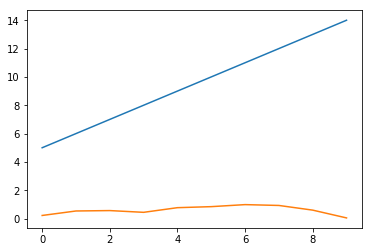

In [49]:
a = np.random.random(10)
b = np.arange(5, 15)
# b = np.random.random(10)
matrix = np.array([b, a]).T
grangercausalitytests(matrix, maxlag=2, verbose=True)
_ = plt.plot(matrix)

In [7]:
# Reject any null hypothesis if p value is below a significant level / statistic value is more extreme than the related critical value
# Weak assumption: If we can't reject a null hypothesis we assume that it's true
# p=100% would mean the null hypothesis is correct. Below 5% we can "safely" reject it
# Link 1: https://stats.stackexchange.com/questions/55805/how-do-you-interpret-results-from-unit-root-tests)
# My Post: https://stats.stackexchange.com/questions/317133/how-to-interpret-kpss-test/371119#371119

# Null hypothesis: is level stationary (with noise) = I(0)
# For instance a ‘shock’ dies away with stationarity but is persistent if non stationary.
def is_stationary(X, debug=True): # = not able to reject null hypothesis
    # Null hypothesis: x is stationary (not trend stationary); Note: test tends to reject too often
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        kpss_stat, p_value, lags, critical_values = stats.kpss(X)
    if debug:
        print('-'*10,' KPSS ','-'*10,)
        print(f'{kpss_stat}, {p_value}, {lags}, {critical_values}')
    return abs(kpss_stat) < abs(critical_values['5%'])
    # Same as return p_value > 0.05

# Null hypothesis: has unit root = I(1)
def has_unit_root(X, debug=True): # = not able to reject null hypothesis
    # Null hypothesis: x has a unit root (= is not stationary, might be trend stationary)
    adf_stat, p_value, used_lag, nobs, critical_values, icbest = stats.adfuller(X)
    if debug:
        print('-'*10,' ADF ','-'*10,)
        print(f'{adf_stat}, {p_value}, {used_lag}, {critical_values}')
    return abs(adf_stat) < abs(critical_values['5%'])
    # Same as return p_value > 0.05

def get_order_of_integration(X, debug=True):
    if has_unit_root(X, debug=debug):
        return 1
    if is_stationary(X, debug=debug):
        return 0
    return 2  # just assumption. usually this shouldn't happen

# Uses the augmented Engle-Granger two-step cointegration test
def are_cointegrated(X1, X2, debug=True): # = able to reject null hypothesis
    X1_order = get_order_of_integration(X1, debug=False)
    X2_order = get_order_of_integration(X2, debug=False)
    if debug:
        print('-'*10,' COINT ','-'*10,)
        print(f'X1: I({X1_order}) - X2: I({X2_order})')
    assert X1_order, f'Timeseries X1 need to be of I(1) but was {X1_order}'
    assert X2_order, f'Timeseries X2 need to be of I(1) but was {X2_order}'
    # Null hypothesis: X1 & X2 are not cointegrated (= is not stationary, might be trend stationary)
    for trend_type in ['c', 'ct', 'ctt']:
        coint_stat, p_value, critical_values = stats.coint(X1, X2, trend_type, maxlag=10)
        if debug:
            print(f'{trend_type}: {coint_stat:.2f}, {p_value:.2f}, {critical_values}')
        if abs(coint_stat) > abs(critical_values[1]):
            break
    return abs(coint_stat) > abs(critical_values[1])
    # Same as return p_value < 0.05

time: 25.9 ms


In [58]:
are_cointegrated(np.arange(5, 105) + np.random.rand(100),  
                 np.arange(100) * np.arange(100) * np.arange(100) * np.array(list(reversed(np.arange(100)))),
                 debug=True)

----------  COINT  ----------
X1: I(1) - X2: I(1)
c: -0.23, 0.98, [-4.01048603 -3.39854434 -3.08756793]
ct: -8.05, 0.00, [-4.48720681 -3.87786858 -3.56858685]


True

In [ ]:
symbols = ds.get_all_prices().symbol.unique()
symbols = [s for s in symbols if ds.get_prices(s).shape[0] == 1762]
features = pd.DataFrame(0, index=symbols, columns=symbols)

In [ ]:
len(symbols)

In [ ]:
for s1, s2 in itertools.combinations(symbols, r=2):
    p1 = ds.get_prices(s1)['open']
    p2 = ds.get_prices(s2)['open']
    print(p1.shape, p2.shape)
    print(s1, s2)
    print(are_cointegrated(p1, p2))